# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 13

**Author 1 (sciper):** Nicolas Kieffer (270647)  
**Author 2 (sciper):** Grégoire Bergamo (274547)   
**Author 3 (sciper):** Maxime Poffet (273555)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

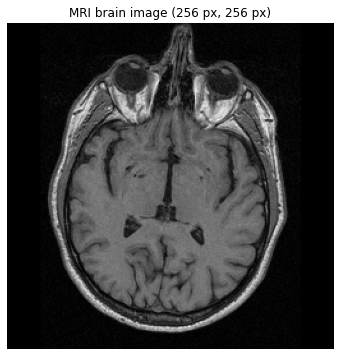

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

### Description

The seed is allready chosen inside the brain. At each cycle of the while loop, we inspect the four neighbors, select only the ones that validates the conditions and then choose the one closest to the intensity mean of the region. This neighbor is added to the region, the mean is recalculated and we start the loop again with this pixel as the new seed. When the none of the four neighbors validate the conditions, we go back to the previous seed and choose the next best pixel. The segmentation is finished when we come back to the original seed.

In [3]:
import numpy as np

def region_growing(img, seed):
    
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    intensity_diff_threshold = 20
    region_size = 1
    intensity_difference = 0
    neighbor_points_list = []
    neighbor_intensity_list = []
    seed_count = 0
    
    #initialisation of the mean
    region_mean = img[seed]
    
    height, width = img.shape
    image_size = height * width
    
    #result array: the pixels in the region will be at 255
    segmented_img = np.zeros((height, width, 1), np.uint8)
    #memory of the place and order of the seed
    seed_order = np.zeros((height, width), np.uint64)
    
    while(True):
        neighbor_points_list = []
        neighbor_intensity_list = []
        counter = 0
        for i in range(4):
            x_temp = seed[0] + neighbors[i][0]
            y_temp = seed[1] + neighbors[i][1]

            inside_image = (x_temp >= 0) & (y_temp >= 0) & (x_temp < height) & (y_temp < width)
            
            #conditions to be potentialy in the region
            if (abs(int(img[x_temp, y_temp])-region_mean) < intensity_diff_threshold) & (inside_image) & (segmented_img[x_temp, y_temp] == 0):
                neighbor_points_list.append([x_temp, y_temp])
                neighbor_intensity_list.append(img[x_temp, y_temp])
                counter += 1
                
        #if no neighbor pixel satisfy the conditions
        #we go to the previous seed
        if (counter == 0):
            seed_order[seed[0], seed[1]] = 0
            seed_count -= 1
            
            #when we are back at the first seed, the segmentation is finished
            if seed_count == 0 or not np.where(seed_order == (seed_count))[0].size > 0: 
                print('The size of the region is : {}px'.format(region_size))
                return segmented_img

            seed[0] = np.where(seed_order == (seed_count))[0][0]
            seed[1] = np.where(seed_order == (seed_count))[1][0]
            
        #if at least one neighbor pixel satisfy the condition  
        #the neighbor the closest to the mean is added to the region and becomes the seed 
        else :
            distance = abs(neighbor_intensity_list-region_mean)
            pixel_distance = min(distance)
            index = np.where(distance == pixel_distance)[0][0]
            region_size += 1
            region_mean = (region_mean*(region_size-1)+img[x_temp,y_temp])/region_size
            seed_count += 1
            seed = neighbor_points_list[index]
            segmented_img[seed[0], seed[1]] = 255
            seed_order[seed[0], seed[1]] = seed_count
    
    

The size of the region is : 15875px


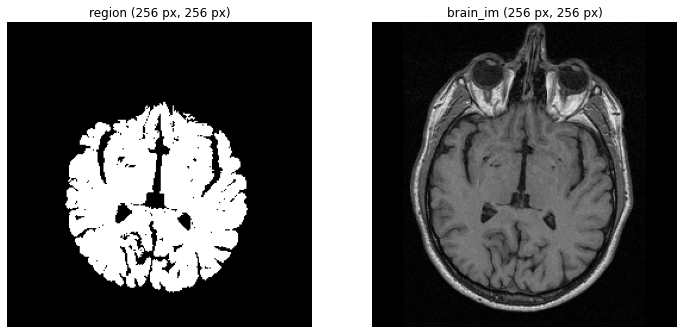

In [4]:
seed = (128, 115) #seed chosen inside the brain

region = region_growing(brain_im, seed)

# Display region
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(region, cmap='gray')
ax[0].set_title('region ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(brain_im, cmap='gray')
ax[1].set_title('brain_im ({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')

plt.show()

### 1.3 Contour detection (5pts)

### Description

The first step is to convert the orginal image into HSV color space. The advantage of HSV is that it separates image intensity so we can extract the brightest zones of the picture. 
Then we find the contour that covers the maximum area and draw it on the orignal picture: that is the brain.
Using this contour, we create a binary brain mask that we can multiply with the original image in order to keep only pixels contained into the brain contour.

The contour detection is and efficient method in the case of findind the biggest area in the picture or the brightest area for example because we can easily extract them. But for small or non c

The size of the brain area is : 16748 px


(-0.5, 255.5, 255.5, -0.5)

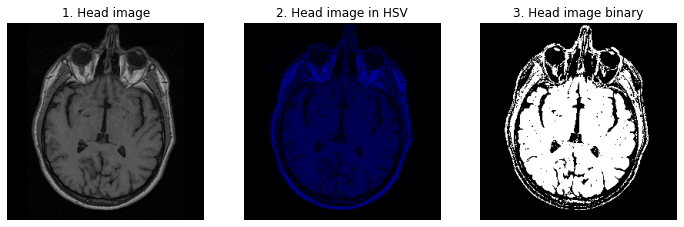

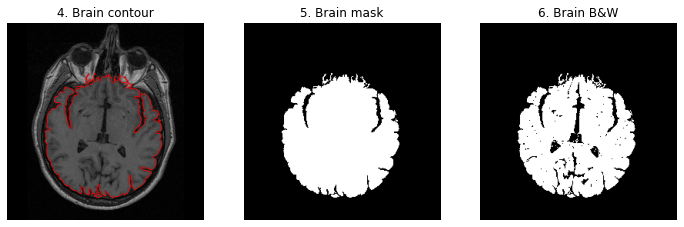

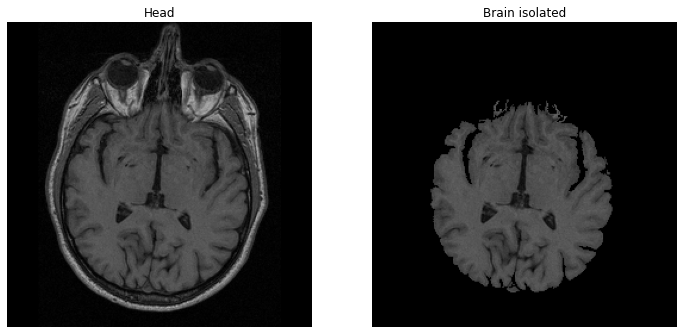

In [5]:
import cv2

# Using a threshold to keep brightest pixels from a HSV picture
head_im = cv2.imread(os.path.join(data_path, 'brain-slice40.tiff'))
head_im_hsv = cv2.cvtColor(head_im, cv2.COLOR_BGR2HSV)
head_im_binary = cv2.inRange(head_im_hsv, (0, 0, 50), (0, 0, 95))

# Find contours in the binary image of the head and especially the one that has the biggest area (the brain)
contours = cv2.findContours(head_im_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]
max_area_cnt = max(contours, key=cv2.contourArea)

# Draw the brain contour in red on the original head picture
brain_contours = head_im.copy()
cv2.drawContours(brain_contours, max_area_cnt, -1, (255, 0, 0))

# Create a binary mask of the brain (pixel=1 inside the contour and pixel=0 outside)
_, brain_mask_contours = cv2.threshold(brain_contours, 255, 255, cv2.THRESH_BINARY)
brain_mask = cv2.fillPoly(brain_mask_contours, pts =[max_area_cnt], color=(255,255,255))
brain_mask = (brain_mask/255).astype(dtype=np.uint8)
brain_mask = cv2.cvtColor(brain_mask, cv2.COLOR_BGR2GRAY)

# Apply the brain mask on the binary image of the head
brain_bw = head_im_binary * brain_mask

# Recreate the brain mask to have compatible sizes and adapted values
brain_mask = cv2.fillPoly(brain_mask_contours, pts =[max_area_cnt], color=(255,255,255))
brain_mask = (brain_mask/255).astype(dtype=np.uint8)

# Apply the brain mask on the original image of the head
brain = head_im * (brain_mask/255)

# Compute the brain area
brain_area = int((brain_bw/255).sum())
print('The size of the brain area is : {} px'. format(brain_area))

# Show processing steps
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(head_im)
ax[0].set_title('1. Head image')
ax[0].axis('off')
ax[1].imshow(head_im_hsv)
ax[1].set_title('2. Head image in HSV')
ax[1].axis('off')
ax[2].imshow(head_im_binary, cmap='gray')
ax[2].set_title('3. Head image binary')
ax[2].axis('off')

fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(brain_contours)
ax[0].set_title('4. Brain contour')
ax[0].axis('off')
ax[1].imshow(brain_mask_contours)
ax[1].set_title('5. Brain mask')
ax[1].axis('off')
ax[2].imshow(brain_bw, cmap='gray')
ax[2].set_title('6. Brain B&W')
ax[2].axis('off')

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(head_im)
ax[0].set_title('Head')
ax[0].axis('off')
ax[1].imshow(brain)
ax[1].set_title('Brain isolated')
ax[1].axis('off')

### 1.4 Additional method (5pts)

### Description

We decided to implement the split and merge method in order to compute the size of the brain in pixel.
To compute this method, we first split the image into four parts, and check if each part is homogeneous or not (by a criteria that we fixed). Thus, if a part is not homogeneous, we split it into 4 new parts and check the last point again. This repeats until we have only homogeneous regions. Finally, we merge some regions, if they are neighbors and if their pixels' mean is close. 

In [6]:
# Function that detect whereas a subregion is homogeneous or not

def homogeneous(x, y, length):
    var_threshold = 40
    var = np.var(brain_im[x:x+length, y:y+length])     # We check if a region is homogeneous or not if the variance of its pixel is not too high
    if var < var_threshold:
        return 1
    else:
        return 0
    

In [7]:
# Split

subregions = ([[0, 0, 256, 0, 0, 0]])
all_1 = 0

while(1):
    size = np.shape(subregions)[0]
    i = 0
    nb = 0
    if all_1 == 1:
        break                                 # Quit if all the subregions are homogeneous
    all_1 = 1
    while nb < size:

        if subregions[i][3] == 0:
            x_init = subregions[i][0]
            y_init = subregions[i][1]
            length = subregions[i][2]
            if homogeneous(x_init, y_init, length):
                subregions[i][3] = 1
                i += 1
                nb += 1
            else:
                all_1 = 0                    # Split a region into four subregions and index their positions and lengths
                subregions = np.concatenate((subregions, [[x_init, y_init, length//2, 0, 0, 0]]), axis = 0)
                subregions = np.concatenate((subregions, [[x_init+length//2, y_init, length//2, 0, 0, 0]]), axis = 0)
                subregions = np.concatenate((subregions, [[x_init, y_init+length//2, length//2, 0, 0, 0]]), axis = 0)
                subregions = np.concatenate((subregions, [[x_init+length//2, y_init+length//2, length//2, 0, 0, 0]]), axis = 0)
                subregions = np.delete(subregions, i, 0)
                nb += 1
        else:
            i += 1
            nb += 1

In [8]:
# Function that detect whereas two subregions are neighbors or not

def neighbors_detection(x1, y1, len1, x2, y2, len2):
    if x2 >= x1 - len2 and x2 <= x1 + len1:
        if y2 >= y1 - len2 and y2 <= y1 + len1:
            return 1
        
    return 0

In [9]:
# Function that compute the difference of pixels' mean between two subregions

def mean(x1, y1, len1, x2, y2, len2):
    mean_threshold = 7.5
    mean1 = np.mean(brain_im[x1:x1+len1, y1:y1+len1])
    mean2 = np.mean(brain_im[x2:x2+len2, y2:y2+len2])
    if abs(mean1 - mean2) < mean_threshold:
        return 1
    else:
        return 0

In [10]:
# Merge

nb_region = 1
region = subregions[0]
size = np.shape(subregions)[0]

while(1):
    find = 0
    for j in range(0, size):
        if subregions[j][4] == 0:              # We find the next element without an assigned region
            find = 1
            break                     

    if find == 0:
        break                                  # We quit if all the subregions have an assigned region
        
    nb_region += 1
    subregions[j][4] = nb_region               # We start to assign a new region
    
    while(1):
        find = 0
        for j in range(0, size):
            if subregions[j][4] == nb_region:
                if subregions[j][5] == 0:       # Find the next one of the same region that has not a done researsh
                    find = 1
                    break            
        
        if find == 0:
            break                               # Quit if no subregion of the same region without a done researsh
        
        i = 0
        while i < size:
            if subregions[i][5] == 0:           # If no researsh with this subregion
                if neighbors_detection(subregions[j][0], subregions[j][1], subregions[j][2], subregions[i][0], subregions[i][1], subregions[i][2]):
                                                # If the two subregions are neighbors
                    if mean(subregions[j][0], subregions[j][1], subregions[j][2], subregions[i][0], subregions[i][1], subregions[i][2]):
                                                # If the two subregions have close pixels' means
                        subregions[i][4] = nb_region
            i += 1
        subregions[j][5] = 1
    
    

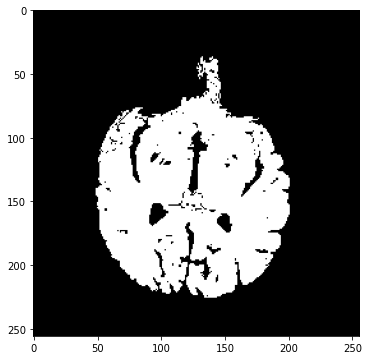

In [11]:
# Display the image of the detected brain 

new_img = np.zeros((256, 256), dtype=int)
for i in range(0, len(subregions)):
    if subregions[i][4] == 3:
        new_img[subregions[i][0]:subregions[i][0]+subregions[i][2], subregions[i][1]:subregions[i][1]+subregions[i][2]] = 50
    
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(new_img, cmap='gray')
plt.show()    

In [12]:
# Count the size of the region in pixels 

nb_px = 0

for i in range(0, 256):
    for j in range(0, 256):
        if new_img[i][j] == 50:
            nb_px += 1
        
print('The size of the region is :', nb_px, 'px')

The size of the region is : 17189 px


---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [13]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


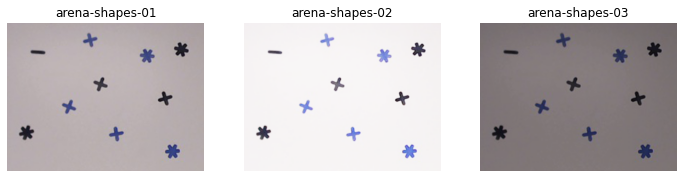

In [14]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [23]:
#function that normalize an image and correct its white balance 
def normalize(img_input):
    
    norm_img = np.zeros((480,640))
    normalized_img = cv2.normalize(img_input, norm_img, 0, 255, cv2.NORM_MINMAX)
    
    whitebalanced = img_as_ubyte(
            (normalized_img*1.0 / np.percentile(normalized_img, 
             95, axis=(0, 1))).clip(0, 1))
    
    return whitebalanced

In [16]:
#funtion that measure the area of labelised regions
def measure_area(labels):
    area = 0
    
    #only the regions bigger than 200px are counted to remove the noise
    for shape in measure.regionprops(labels):
        if shape.area >= 200:
            area += shape.area
    
    return area

In [20]:
#segmentation using color correction and multiple thresholds
from skimage import measure
from skimage import img_as_ubyte

def count_number_shapes(img):

    image_blue = img[:,:,2].copy()
    image_red = img[:,:,0].copy()
    image_green = img[:,:,1].copy()
    
    
    #extract the black shapes from the blue channel
    black_shapes = np.zeros(image_blue.shape[0:2])
    black_shapes[image_blue<140] = 255
    
    #extract the blue shapes from the blue and red channel
    blue_shapes = np.zeros(image_blue.shape[0:2])
    blue_shapes[(image_red<160) & (image_blue>160)] = 255
        

    # Display
    fig, ax = plt.subplots(1, 3, figsize=(12, 12))
    
    ax[0].imshow(img)
    ax[0].set_title('normalized image')
    ax[0].axis('off')
    ax[1].imshow(black_shapes, cmap='gray')
    ax[1].set_title('black shapes')
    ax[1].axis('off')
    ax[2].imshow(blue_shapes, cmap='gray')
    ax[2].set_title('blue shapes')
    ax[2].axis('off')
    
    plt.show()

    labels_black = measure.label(black_shapes)
    labels_blue = measure.label(blue_shapes)
    black_count = 0
    blue_count = 0
    
    #Count only the shapes with an area bigger than 200px
    for shape in measure.regionprops(labels_black):
        if shape.area >= 200:
            black_count +=1

    for shape in measure.regionprops(labels_blue):
        if shape.area >= 200:
            blue_count +=1     
            
    
    print('number of black shapes : {}'.format(black_count))
    print('number of blue shapes : {}'.format(blue_count))
    
    black_area = measure_area(labels_black)
    blue_area = measure_area(labels_blue)
    print('area of black shapes : {}'.format(black_area))
    print('area of blue shapes : {}\n\n'.format(blue_area))



FIRST IMAGE:


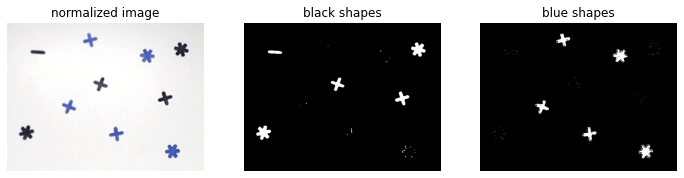

number of black shapes : 5
number of blue shapes : 5
area of black shapes : 4582
area of blue shapes : 4268


SECOND IMAGE:


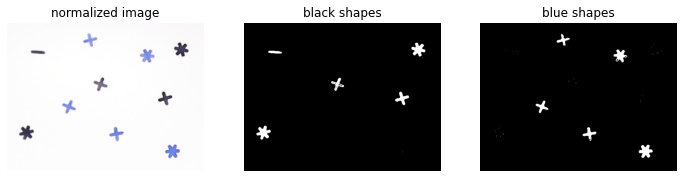

number of black shapes : 5
number of blue shapes : 5
area of black shapes : 3889
area of blue shapes : 3899


THIRD IMAGE:


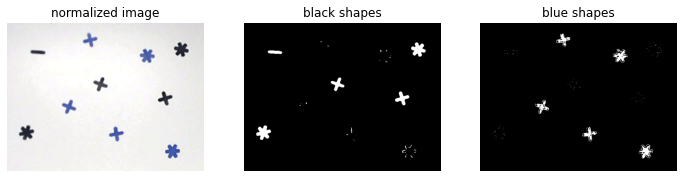

number of black shapes : 5
number of blue shapes : 5
area of black shapes : 4697
area of blue shapes : 3654




In [22]:
print('FIRST IMAGE:')
image_1_norm = normalize(images[0])
count_number_shapes(image_1_norm)

print('SECOND IMAGE:')
image_2_norm = normalize(images[1])
count_number_shapes(image_2_norm)

print('THIRD IMAGE:')
image_3_norm = normalize(images[2])
count_number_shapes(image_3_norm)



### 2.3 Total area (in pixels) of each color (5 pts)

We measured the area in the chapter 2.2